In [2]:
import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../data/test\1030_jpg.rf.4bfc0ebc72d835cb9668219cd911c249.jpg
../data/test\1035_jpg.rf.0dead1ccbe6b1e137ca2d98fc4d34b9a.jpg
../data/test\1056_jpg.rf.f539615badbea313d68c957e76642dda.jpg
../data/test\1058_jpg.rf.f6d6dcde9564c091b30eb6873641ba36.jpg
../data/test\1083_jpg.rf.b1473a76f8f3789c6be693dfbe9bc011.jpg
../data/test\1093_jpg.rf.4cde54a1271fe5ecc1f9d6ca4b00f835.jpg
../data/test\1125_jpg.rf.6a2f54deeac86ff2d961132a828c9ae6.jpg
../data/test\1126_jpg.rf.d216bd33f5b8f7f557d14928c232a377.jpg
../data/test\1130_jpg.rf.d1672624856f1df581acc128aea4a635.jpg
../data/test\1136_jpg.rf.02df64849485272e48139498c36c8e44.jpg
../data/test\1140_jpg.rf.f8a48ff0879568ff23cd511711ef650e.jpg
../data/test\1151_jpg.rf.17b666e0803c2fcd6b5b292fadf7afd5.jpg
../data/test\1174_jpg.rf.336d0729fe53adf926746fe2fe9cd0df.jpg
../data/test\1198_jpg.rf.23baa1a977b7581326b0d7758f2dcc88.jpg
../data/test\1203_jpg.rf.be8a48f34842f2c23a84b8b367618dce.jpg
../data/test\1209_jpg.rf.e4323403c999a44e8c47683ce6a9070e.jpg
../data/

In [3]:
#jason import 
import json 

In [8]:
with open('../data/valid/_annotations.coco.json','r') as file:
    data = json.load(file)

for img in data['images'][:10]:
    print(img['file_name'])

1997_jpg.rf.57e306420710246d04c0d5c26e6496c6.jpg
2422_jpg.rf.59a35b6d8d2eed150af8535cf09bbde5.jpg
1630_jpg.rf.5afc6e25d7987503a11bcb0791b60b53.jpg
1330_jpg.rf.5b23bf18a29b0f50e376b19a5a84f823.jpg
2768_jpg.rf.5b87c0023909e0789a33185a3aab92e9.jpg
2647_jpg.rf.5ba404374f2d670f04a2d1367c77c039.jpg
1511_jpg.rf.5c02bb67a267960293c9e8393c2d9380.jpg
1018_jpg.rf.5c6fcb4480745ff7c60c7305781913ab.jpg
1694_jpg.rf.5c8d647ce366cbd41426af5217863bd4.jpg
2824_jpg.rf.5ca7452639b345dfd0206a58531b6910.jpg


In [9]:
data['categories']

[{'id': 0, 'name': 'Tumor', 'supercategory': 'none'},
 {'id': 1, 'name': '0', 'supercategory': 'Tumor'},
 {'id': 2, 'name': '1', 'supercategory': 'Tumor'}]

In [11]:
#To see the structure of the json file 
def print_structure (d, indent=0):
    if isinstance(d,dict):
        for key , value in d.items():
            print(' ' * indent + str(key))
            print_structure(value,indent+1)
    elif isinstance(d, list):
        print(' ' * indent + "list of length {} containing : ".format(len(d)))
        if d:
            print_structure(d[0],indent+1) # only print the structure of the first item

with open('../data/valid/_annotations.coco.json','r') as file:
    data = json.load(file)

In [12]:
#the structure of json data
print_structure(data)

info
 year
 version
 description
 contributor
 url
 date_created
licenses
 list of length 1 containing : 
  id
  url
  name
categories
 list of length 3 containing : 
  id
  name
  supercategory
images
 list of length 429 containing : 
  id
  license
  file_name
  height
  width
  date_captured
annotations
 list of length 429 containing : 
  id
  image_id
  category_id
  bbox
   list of length 4 containing : 
  area
  segmentation
   list of length 1 containing : 
    list of length 10 containing : 
  iscrowd


# Data Visualization

In [4]:
#IMPORTS
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
import numpy as np
import random 


In [14]:
def display_masks(image_names, data):
    fig , ax = plt.subplots(2,2,figsize = (15,15))
    for i, img_path in enumerate(image_names):
        draw_image = cv2.imread(img_path)
        img_filename = os.path.basename(img_path)
        img_id = [item for item in data['images'] if item['file_name'] == img_filename][0]['id']
        img_annotations = [ann for ann in data['annotations'] if ann['image_id'] == img_id]
        points_list = img_annotations[0]['segmentation']
        points = np.array(points_list, np.int32)
        points = points.reshape((-1,1,2))
        # Draw polygon
        cv2.polylines(draw_image,[points],True,(0,0,255),3)
        
        # Display the image
        ax[i//2, i%2].imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
        ax[i//2, i%2].axis('off')
    plt.show()

        

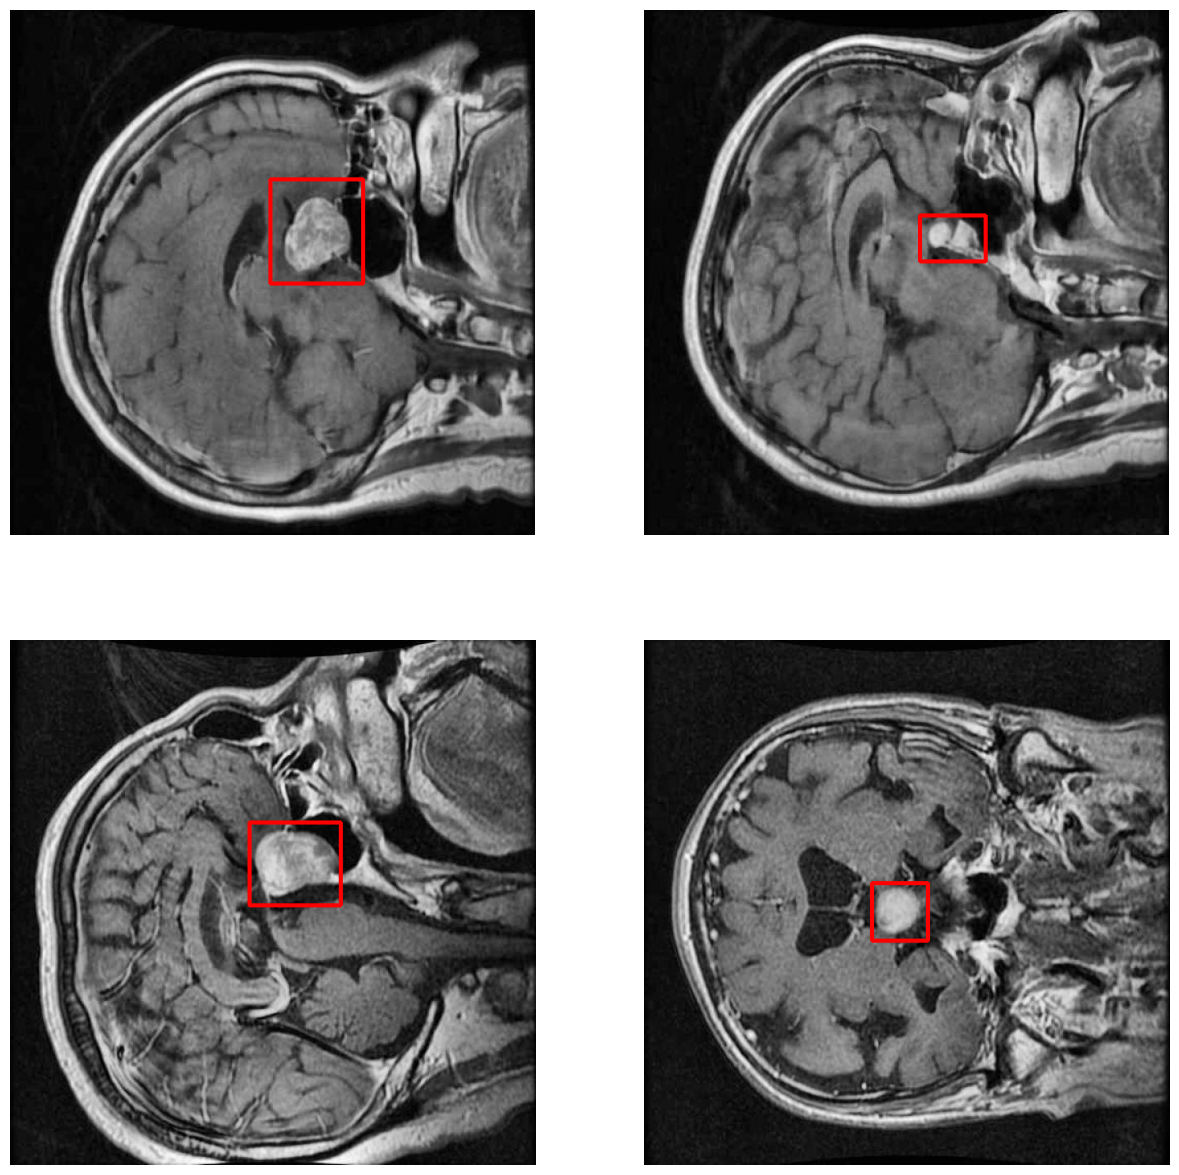

In [15]:
#Loading the data for visualization part
with open('../data/valid/_annotations.coco.json','r') as file:
    annotations = json.load(file)
#get all the image files
imge_dir = "../data/valid"
all_image_files = [os.path.join(imge_dir,img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files,4)
#call the draw mask function
display_masks(random_image_files,annotations)

# CONVERT JSON FILE TO MASK OUTPUT

In [5]:
#Function to create binary mask out from the json format
import json
import numpy as np
import skimage.draw
import tifffile
import os
import shutil
import matplotlib.pyplot as plt

def create_mask(image_info, annotations, output_folder, max_print=3):
    # Create an empty mask as a numpy array
    mask_np = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
    object_number = 1
    printed_masks = 0  # Counter for the number of printed masks
    for ann in annotations:
        if ann['image_id'] == image_info['id']:
            for seg_idx, seg in enumerate(ann['segmentation']):
                rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
                # Create a mask for each segmentation
                seg_mask = np.zeros_like(mask_np, dtype=np.uint8)
                seg_mask[rr, cc] = 255  # Set the pixel values to 255 for the polygon
                mask_path = os.path.join(output_folder, f"{image_info['file_name'].replace('.jpg', '')}_seg_{seg_idx}.tif")
                tifffile.imwrite(mask_path, seg_mask)
                printed_masks += 1
                if printed_masks >= max_print:
                    return  # Exit the function if maximum number of masks to print is reached

In [17]:
def main(json_file, mask_output_folder, image_output_folder, original_image_dir):
    # Load COCO JSON annotations
    with open(json_file, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']

    # Ensure the output directories exist
    if not os.path.exists(mask_output_folder):
        os.makedirs(mask_output_folder)
    if not os.path.exists(image_output_folder):
        os.makedirs(image_output_folder)

    for img in images:
        # Create the masks
        create_mask(img, annotations, mask_output_folder)
        # Copy original images to the specified folder
        original_image_path = os.path.join(original_image_dir, img['file_name'])
        new_image_path = os.path.join(image_output_folder, os.path.basename(original_image_path))
        shutil.copy2(original_image_path, new_image_path)

In [18]:
original_image_dir = '../data/test'  # Where your original images are stored
json_file = '../data/test/_annotations.coco.json'
mask_output_folder = 'test2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = 'test2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = '../data/train'  # Where your original images are stored
json_file = '../data/train/_annotations.coco.json'
mask_output_folder = 'train2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = 'train2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)

original_image_dir = '../data/valid'  # Where your original images are stored
json_file = '../data/valid/_annotations.coco.json'
mask_output_folder = 'valid2/masks'  # Modify this as needed. Using val2 so my data is not overwritten
image_output_folder = 'valid2/images'  # 
main(json_file, mask_output_folder, image_output_folder, original_image_dir)


In [19]:
import os

def compare_folders_and_delete(folder1_path, folder2_path):
    folder1_items = os.listdir(folder1_path)
    folder2_items = os.listdir(folder2_path)

    for item1 in folder1_items:
        found = False
        for item2 in folder2_items:
            if item1[:4] == item2[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item1} not found.")
            item1_path = os.path.join(folder1_path, item1)
            os.remove(item1_path)
            print(f"Deleted {item1}")

    for item2 in folder2_items:
        found = False
        for item1 in folder1_items:
            if item2[:4] == item1[:4]:
                found = True
                break
        if not found:
            print(f"Corresponding item for {item2} not found.")
            item2_path = os.path.join(folder2_path, item2)
            os.remove(item2_path)
            print(f"Deleted {item2}")

# Example usage:
folder1_path = "./train2/images"
folder2_path = "./train2/masks"
compare_folders_and_delete(folder1_path, folder2_path)

Corresponding item for 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg not found.
Deleted 2369_jpg.rf.8b8afa9d79c61fa42ca128c940b9cbc0.jpg


# Custom Dataset creation

In [17]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset_general(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, "images")
        self.mask_folder = os.path.join(root_dir, "masks")
        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Read image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale

        # Read corresponding mask
        mask_name = self.mask_files[idx]
        mask_path = os.path.join(self.mask_folder, mask_name)
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            # Apply transformations
            image_gray = self.transform(image_gray)
            mask = self.transform(mask)

        return image_gray, mask

# Define paths for train, validation, and test sets
train_path = "./train2" 
valid_path = "./valid2"
test_path = "./test2"

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

image_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.8, 1.2)),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Create datasets
train_dataset = CustomDataset_general(train_path, transform=image_train_transform)
valid_dataset = CustomDataset_general(valid_path, transform=image_transform)
test_dataset = CustomDataset_general(test_path, transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
x, y = next(iter(train_loader))
x.shape , y.shape , type(x) , type(y)

(torch.Size([32, 1, 224, 224]),
 torch.Size([32, 1, 224, 224]),
 torch.Tensor,
 torch.Tensor)

In [16]:
! pip install segmentation-models-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 910.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=cff1df2361bdfeb1e60d718af239e463fcc9d7d8332402dbd408aa767b19f73e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=f13a7d195e1f678696a57522d3401bfe5de8c318bfb490314daf227e568420f7
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficie

In [12]:
import torch
from torchvision import datasets
from torch.utils.data import Dataset ,DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.optim import lr_scheduler

In [11]:
import segmentation_models_pytorch as smp


ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cpu'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels=1, 
    classes=1, 
    activation=ACTIVATION,
)

In [13]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    track_loss = 0
    num_correct = 0
    total_samples = 0

    for i, (image, labels) in enumerate(dataloader):
        imgs = image.to(DEVICE)
        labels = labels.to(DEVICE).float()  # Ensure labels are float for binary comparison
        
        pred = model(imgs)
        
        # Computing the loss for the function
        loss = loss_fn(pred, labels)
        track_loss += loss.item()
        
        # Calculating the number of correct predictions (binary case)
        predicted_classes = (pred > 0.5).float()  # Convert logits to binary (0/1)
        correct_predictions = (predicted_classes == labels).sum().item()  # Count correct pixels
        num_correct += correct_predictions
        
        # Total samples should count all pixels in the batch
        total_samples += labels.numel()  # Count total number of pixels
        
        # Calculate running loss and accuracy
        running_loss = track_loss / (i + 1)
        running_acc = (num_correct / total_samples) * 100  # accuracy in percentage
        
        # Perform backpropagation and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print(f"Batch {i + 1}/{len(dataloader)} | Running Loss: {running_loss:.4f} | Running Accuracy: {running_acc:.2f}%")
    
    # Return the epoch loss and accuracy
    epoch_loss = running_loss
    epoch_acc = running_acc
    return epoch_loss, epoch_acc


Epoch No: 1
Batch 1/47 | Running Loss: 0.2058 | Running Accuracy: 97.22%
Training: Epoch Loss: 0.1822, Epoch Accuracy: 97.6177
--------------------------------------------------
Checkpoint saved at Epoch 1 with loss 0.1822
Epoch No: 2
Batch 1/47 | Running Loss: 0.1552 | Running Accuracy: 98.33%
Training: Epoch Loss: 0.1418, Epoch Accuracy: 98.2999
--------------------------------------------------
Checkpoint saved at Epoch 2 with loss 0.1418
Epoch No: 3
Batch 1/47 | Running Loss: 0.1253 | Running Accuracy: 98.53%
Training: Epoch Loss: 0.1123, Epoch Accuracy: 98.6347
--------------------------------------------------
Checkpoint saved at Epoch 3 with loss 0.1123
Epoch No: 4
Batch 1/47 | Running Loss: 0.1029 | Running Accuracy: 98.80%
Training: Epoch Loss: 0.0923, Epoch Accuracy: 98.7534
--------------------------------------------------
Checkpoint saved at Epoch 4 with loss 0.0923
Epoch No: 5
Batch 1/47 | Running Loss: 0.0822 | Running Accuracy: 98.98%
Training: Epoch Loss: 0.0761, Epoch

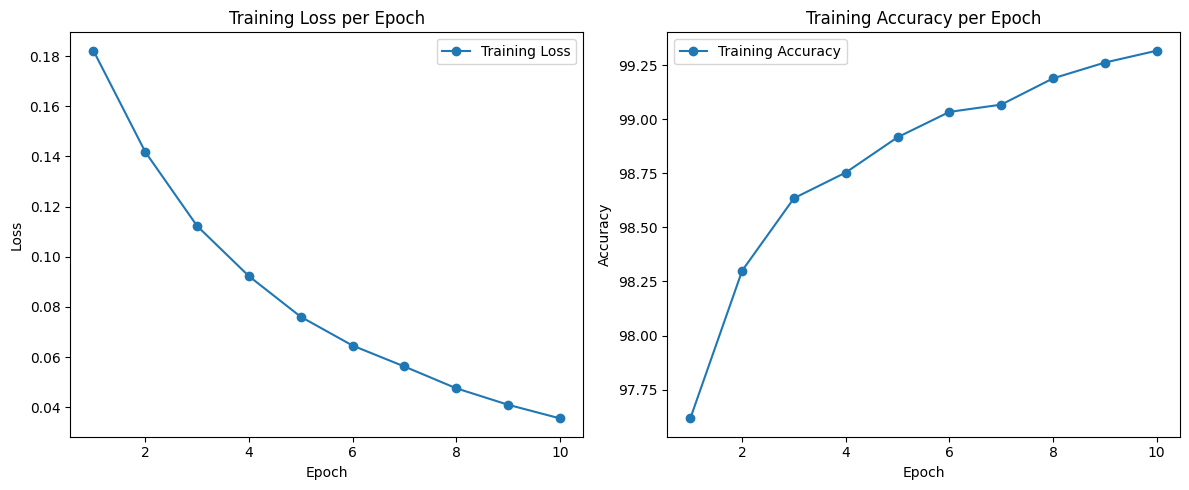

In [61]:
# Initialize lists to store loss and accuracy for each epoch
train_losses = []
train_accuracies = []

model = model.to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
lr = 0.0001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs = 10
best_loss = float('inf')  # Variable to track the best loss
best_checkpoint_path = "best_model_checkpoint.pth"  # File path for saving the best model

# Training loop with checkpointing
for epoch in range(n_epochs):
    print("Epoch No:", epoch + 1)
    
    # Training for one epoch
    train_epoch_loss, train_epoch_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
    
    # Append the loss and accuracy to lists for plotting later
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc)
    
    print(f"Training: Epoch Loss: {train_epoch_loss:.4f}, Epoch Accuracy: {train_epoch_acc:.4f}")
    print("--------------------------------------------------")
    
    # Save checkpoint if the current epoch's loss is the best so far
    if train_epoch_loss < best_loss:
        best_loss = train_epoch_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, best_checkpoint_path)
        print(f"Best model saved at Epoch {epoch + 1} with loss {train_epoch_loss:.4f}")

# After training, plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plotting the loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label="Training Loss", marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label="Training Accuracy", marker='o')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
train_accuracies = []

# Initialize model, loss function, and optimizer just like before
model = model.to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
lr = 0.0001
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
checkpoint_path = f"best_model_checkpoint.pth"  # Path to the saved checkpoint

# Function to load the checkpoint
def load_checkpoint(model, optimizer, checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_loss = checkpoint['loss']
        print(f"Checkpoint loaded from epoch {start_epoch} with best loss {best_loss:.4f}")
        return start_epoch, best_loss
    except FileNotFoundError:
        print(f"Checkpoint {checkpoint_path} not found. Starting from scratch.")
        return 0, float('inf')

# Load checkpoint (if it exists)
start_epoch, best_loss = load_checkpoint(model, optimizer, checkpoint_path)

# Set the total number of epochs for further training
total_epochs = 20 
n_epochs = start_epoch + total_epochs

# Training loop with checkpointing
for epoch in range(start_epoch, n_epochs):
    print("Epoch No:", epoch + 1)
    
    # Training for one epoch
    train_epoch_loss, train_epoch_acc = train_one_epoch(train_loader, model, loss_fn, optimizer)
    
    # Append the loss and accuracy to lists for plotting later
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc)
    
    print(f"Training: Epoch Loss: {train_epoch_loss:.4f}, Epoch Accuracy: {train_epoch_acc:.4f}")
    print("--------------------------------------------------")
    
    # Save checkpoint if the current epoch's loss is the best so far
    if train_epoch_loss < best_loss:
        best_loss = train_epoch_loss
        best_checkpoint_path = f"best_model_checkpoint.pth"  # Save the best model only
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, best_checkpoint_path)
        print(f"Best model saved at Epoch {epoch + 1} with loss {train_epoch_loss:.4f}")

# After training, plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plotting the loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
def load_model(checkpoint_path, model, optimizer=None):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    
    print(f"Model loaded from epoch {start_epoch} with loss {best_loss:.4f}")
    
    return model, optimizer, start_epoch, best_loss

In [21]:
checkpoint_path = "best_model_checkpoint.pth" 
model, optimizer, start_epoch, best_loss = load_model(checkpoint_path, model, optimizer)
model = model.to(DEVICE)

C:\Users\thita\AppData\Local\Temp\ipykernel_20436\1762134666.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model loaded from epoch 10 with loss 0.0356


In [57]:
# Function to overlay mask and bounding box without text and to show grayscale images
def visualize_input_output_target_with_boxes(input_image, output_image, target_image):
    # Move tensors to CPU memory if they are on CUDA devices
    input_image = input_image.cpu()
    output_image = output_image.cpu()
    target_image = target_image.cpu()

    # Convert input image and mask to NumPy arrays
    input_image_np = input_image.squeeze().numpy()
    output_image_np = output_image.squeeze().numpy()
    target_image_np = target_image.squeeze().numpy()

    # Convert input image to BGR for drawing bounding boxes using OpenCV
    input_image_bgr = cv2.cvtColor((input_image_np * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Draw bounding box around the predicted mask
    x_pred, y_pred, w_pred, h_pred = cv2.boundingRect(output_image_np.astype(np.uint8))  # Get bounding box for predicted mask
    input_image_with_pred_box = input_image_bgr.copy()

    # Draw bounding box for predicted mask (without text)
    cv2.rectangle(input_image_with_pred_box, (x_pred, y_pred), (x_pred + w_pred, y_pred + h_pred), (0, 255, 0), 2)

    # Draw bounding box around the ground truth mask
    x_gt, y_gt, w_gt, h_gt = cv2.boundingRect(target_image_np.astype(np.uint8))  # Get bounding box for ground truth mask
    input_image_with_gt_box = input_image_bgr.copy()
    cv2.rectangle(input_image_with_gt_box, (x_gt, y_gt), (x_gt + w_gt, y_gt + h_gt), (255, 0, 0), 2)

    # Create figure with 2 rows (grayscale and box view)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # First row - grayscale style
    axes[0, 0].imshow(input_image_np, cmap='gray')
    axes[0, 0].set_title('Input Image (Grayscale)')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(output_image_np, cmap='gray')
    axes[0, 1].set_title('Predicted Mask (Grayscale)')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(target_image_np, cmap='gray')
    axes[0, 2].set_title('Ground Truth Mask (Grayscale)')
    axes[0, 2].axis('off')

    # Second row - bounding box and mask overlay
    axes[1, 0].imshow(input_image_np, cmap='gray')
    axes[1, 0].set_title('Input Image')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(input_image_with_pred_box)
    axes[1, 1].imshow(np.ma.masked_where(output_image_np == 0, output_image_np), cmap='hot', alpha=0.6)  # Overlay predicted mask
    axes[1, 1].set_title('Predicted Mask with Box')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(input_image_with_gt_box)
    axes[1, 2].imshow(np.ma.masked_where(target_image_np == 0, target_image_np), cmap='hot', alpha=0.6)  # Overlay ground truth mask
    axes[1, 2].set_title('Ground Truth Mask with Box')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [70]:
import time

# Function to predict and visualize with controlled seed for reproducibility
def predict_and_visualize_with_seed(loader, loader_name, model, loss_fn, seed):
    print(f"Predicting for {loader_name} set with seed: {seed}")
    
    # Set the seed for reproducibility (ensuring same randomization)
    np.random.seed(seed)
    
    total_time = 0
    num_images = 0
    total_loss = 0
    total_correct = 0
    total_pixels = 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(loader):
            X = X.to(DEVICE, dtype=torch.float32)
            y = y.to(DEVICE, dtype=torch.float32)
            
            start_time = time.time()  # Start the timer

            # Get model predictions
            y_pred_logits = model(X)
            
            end_time = time.time()  # Stop the timer
            elapsed_time = end_time - start_time  # Calculate elapsed time
            
            total_time += elapsed_time
            num_images += X.size(0)
            
            # Calculate loss
            loss = loss_fn(y_pred_logits, y)
            total_loss += loss.item()

            # Apply threshold to get binary masks
            y_pred_binary = (y_pred_logits > 0.5).float()

            # Randomly select 3 images from the batch based on seed
            selected_indices = np.random.choice(len(X), 3, replace=False)
            
            # Visualize the randomly selected images with grayscale and box overlays
            for i in selected_indices:
                visualize_input_output_target_with_boxes(X[i], y_pred_binary[i], y[i])

            # Calculate accuracy for the selected images
            correct_pixels = (y_pred_binary == y).sum().item()
            total_correct += correct_pixels
            total_pixels += torch.numel(y)

            print(f"Prediction time for {X.size(0)} images: {elapsed_time:.4f} seconds")

            # Stop after visualizing the first batch
            break
        
        # Calculate average loss, accuracy, and prediction time per image
        avg_loss = total_loss / num_images
        avg_acc = (total_correct / total_pixels) * 100
        avg_time_per_image = total_time / num_images

        print(f"Average loss for {loader_name}: {avg_loss:.4f}")
        print(f"Average accuracy for {loader_name}: {avg_acc:.2f}%")
        print(f"Average prediction time per image: {avg_time_per_image:.4f} seconds")

# Define loss function (e.g., binary cross-entropy with logits)
loss_fn = torch.nn.BCEWithLogitsLoss()

Predicting for Validation set with seed: 154


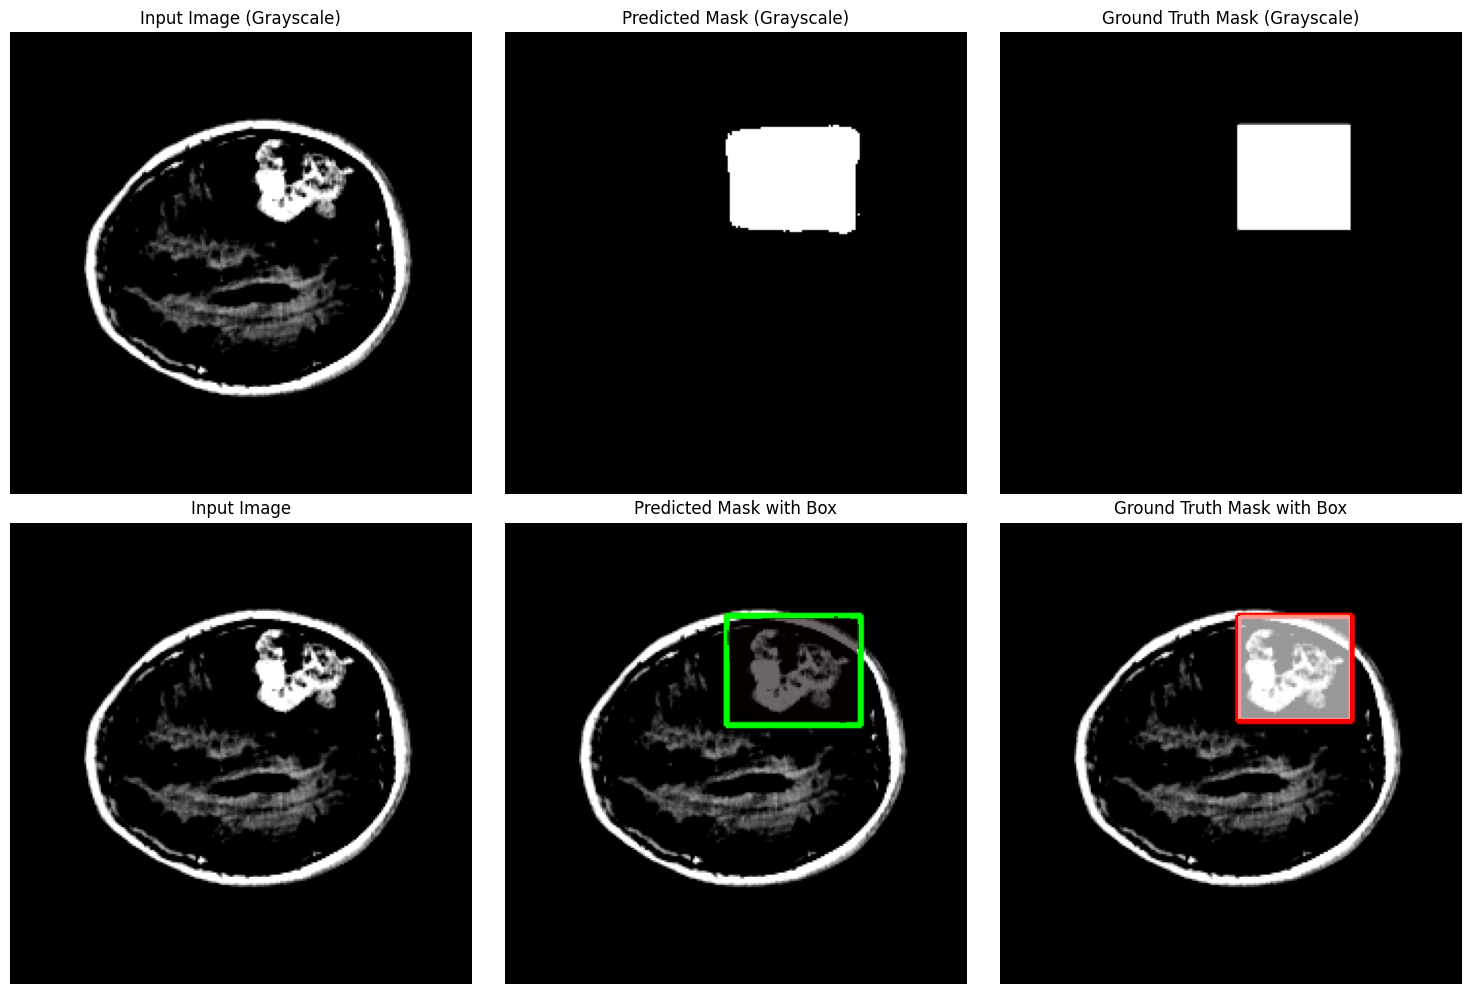

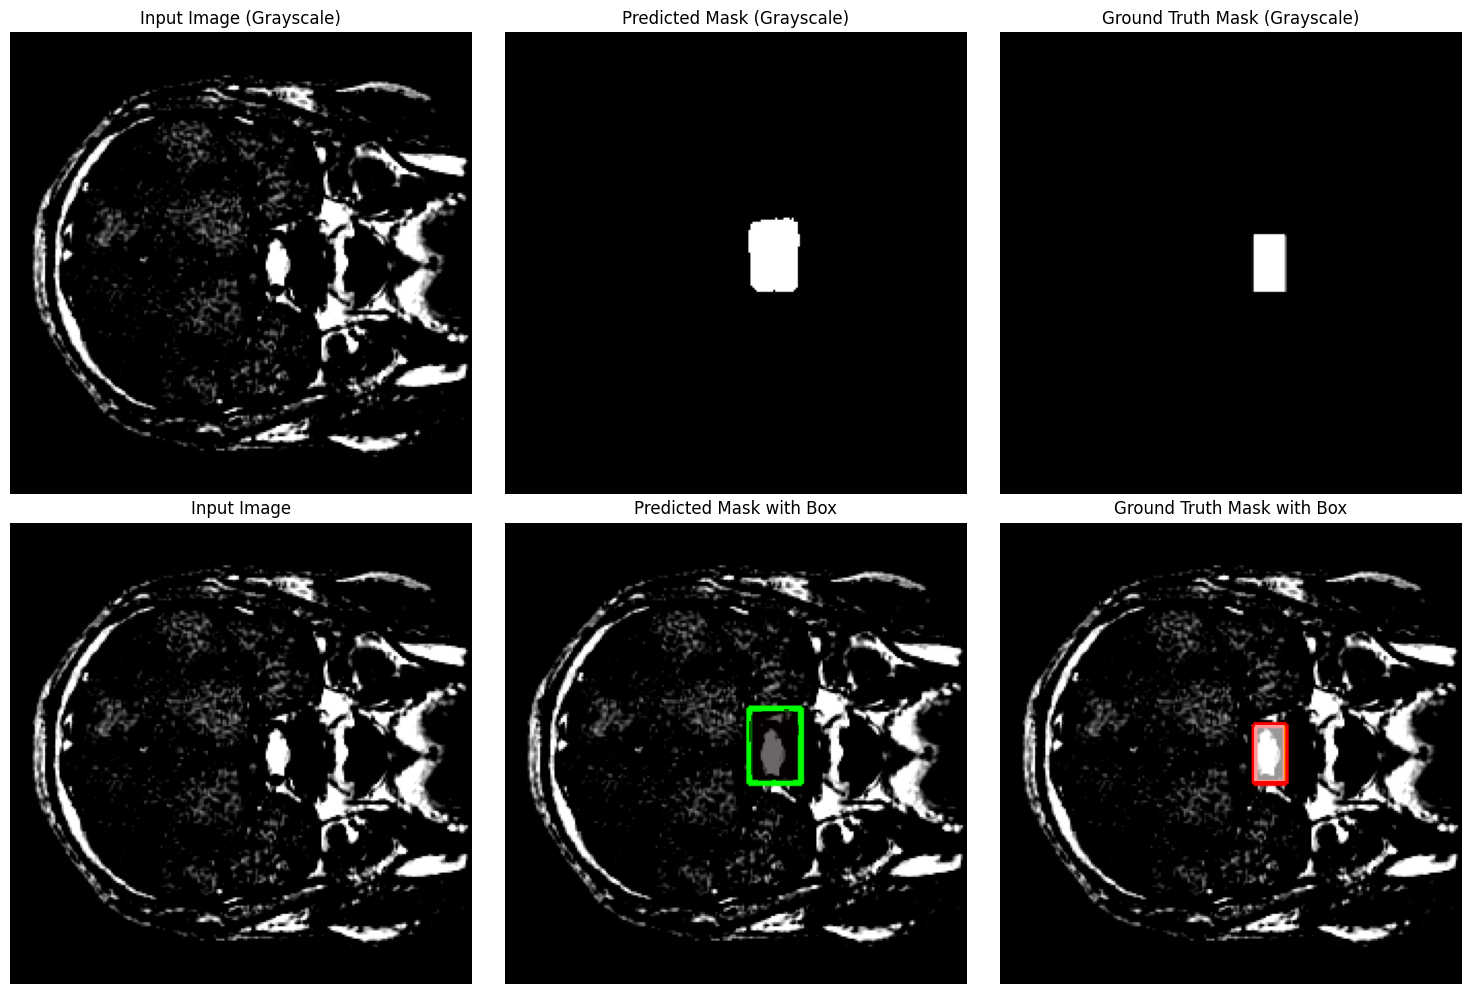

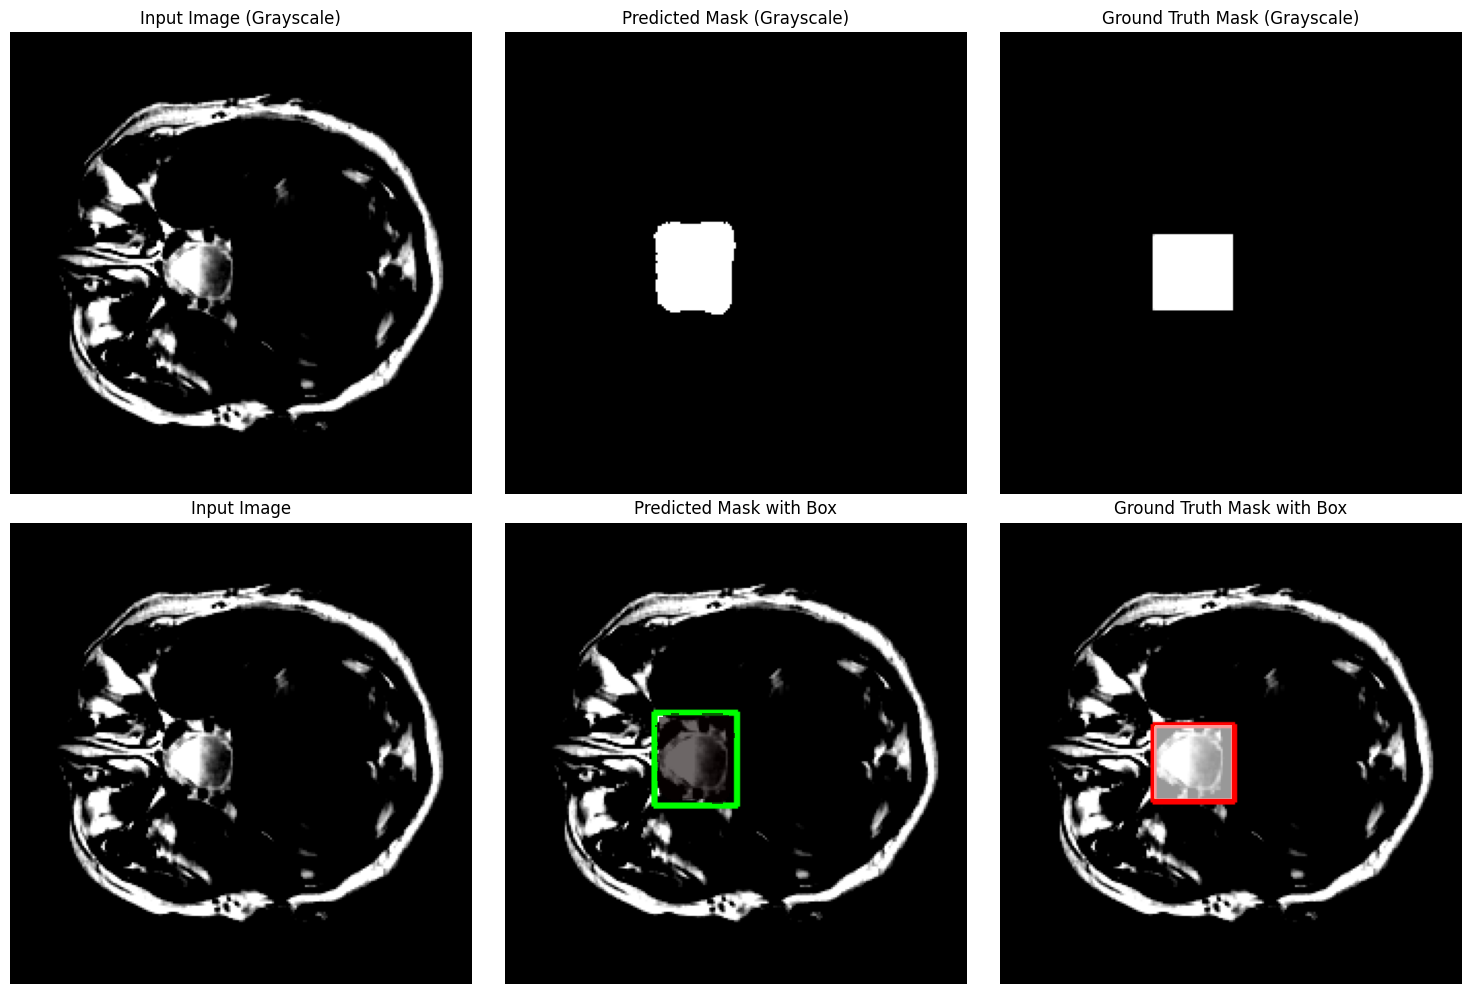

Prediction time for 32 images: 8.7827 seconds
Average loss for Validation: 0.0016
Average accuracy for Validation: 98.98%
Average prediction time per image: 0.2745 seconds
Predicting for Test set with seed: 51


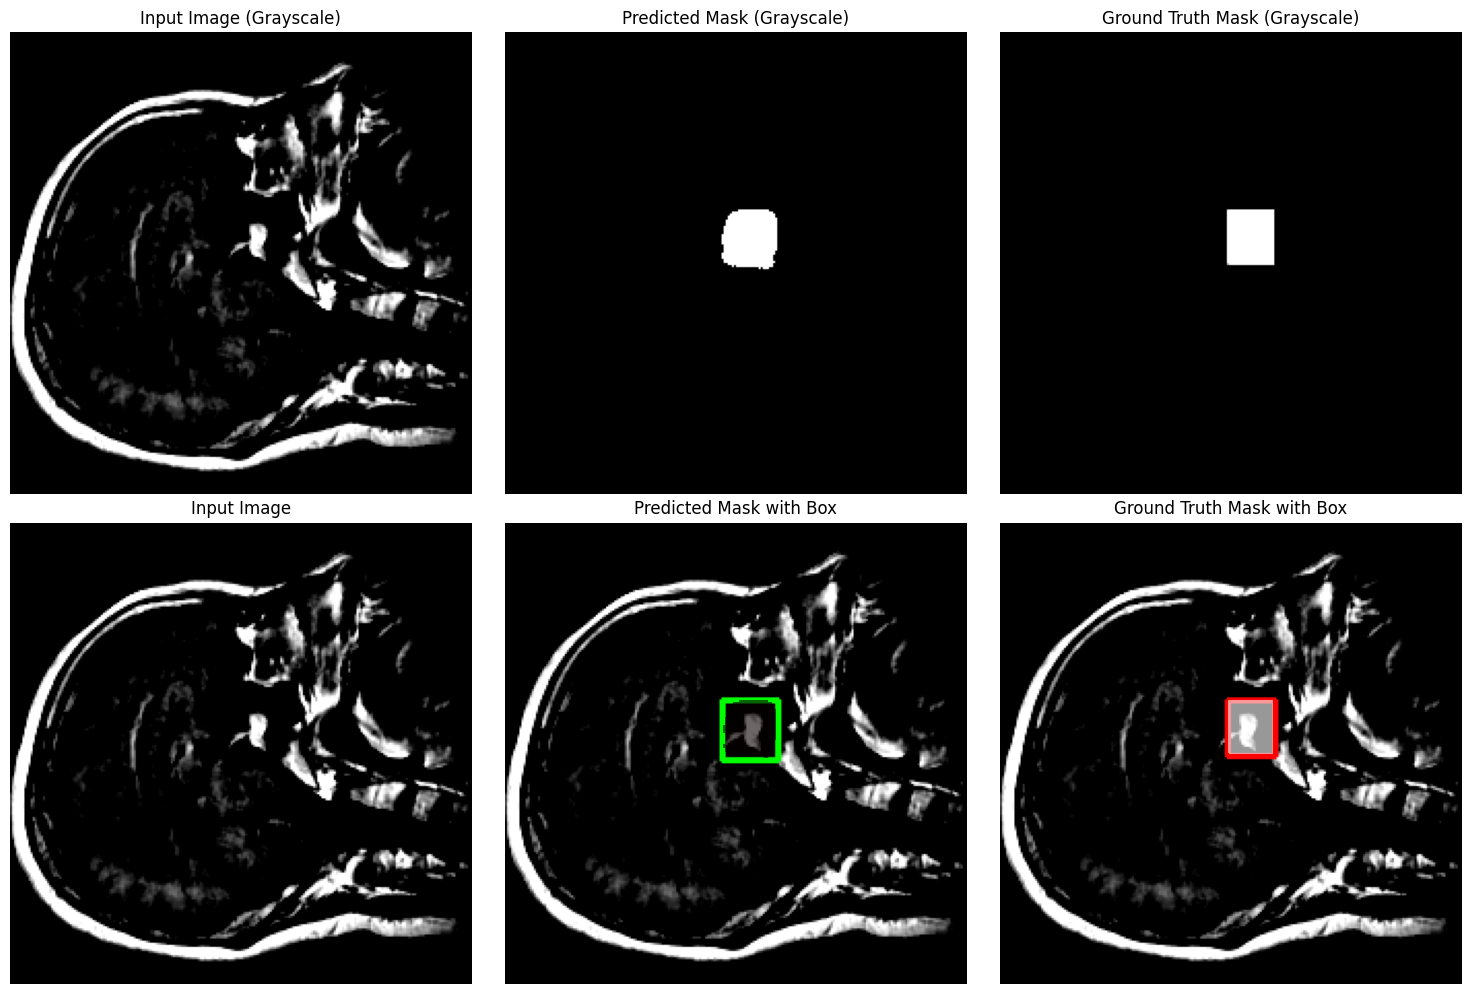

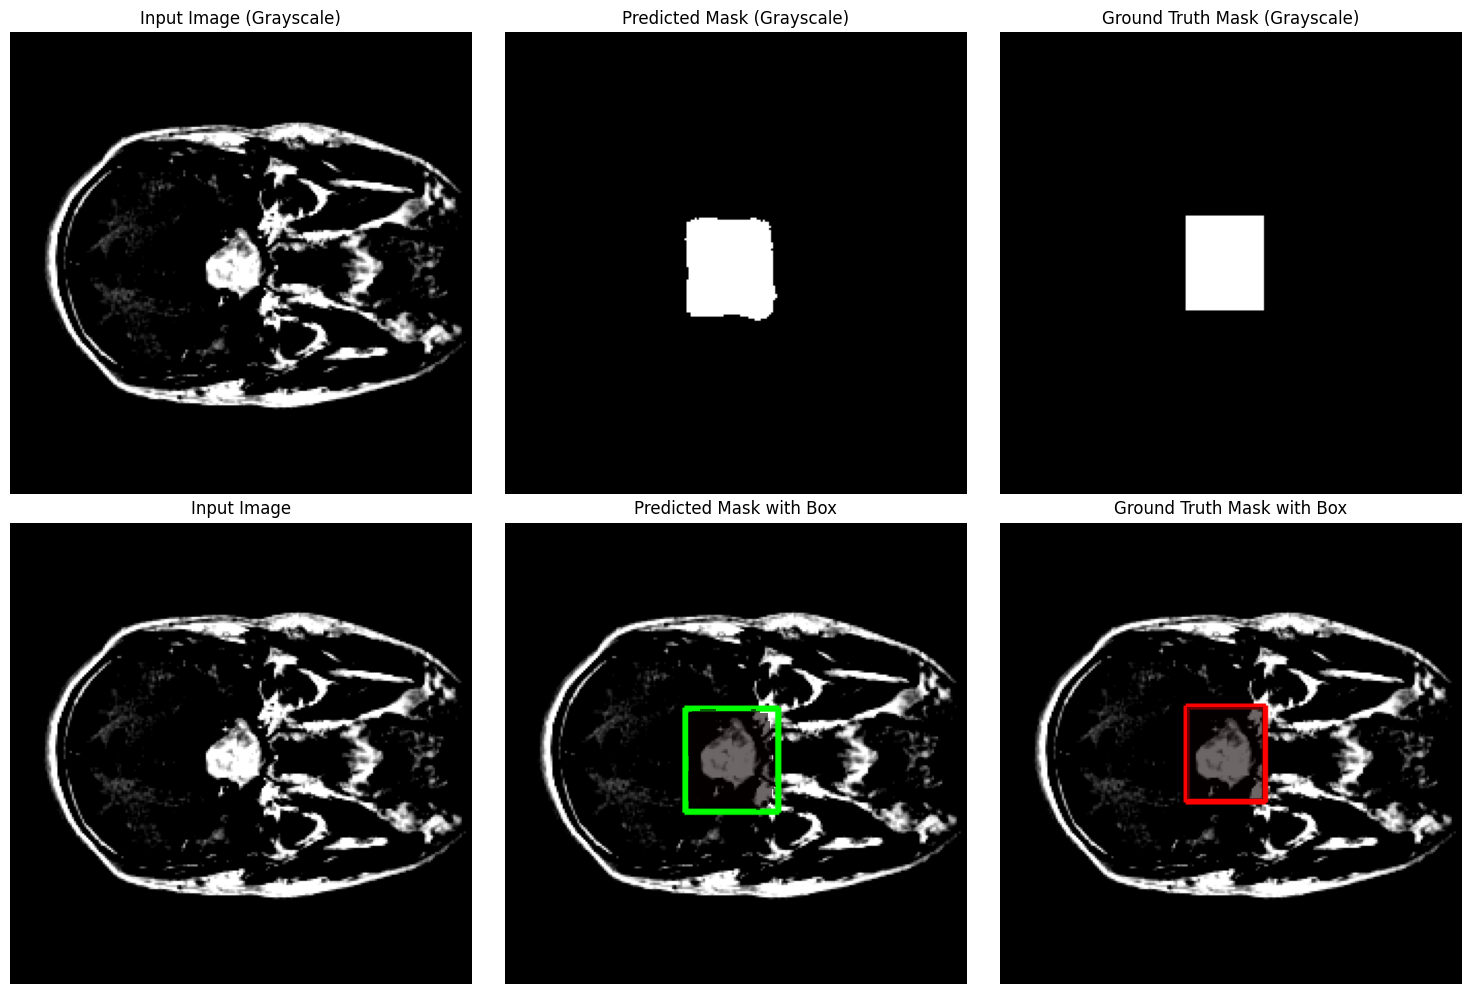

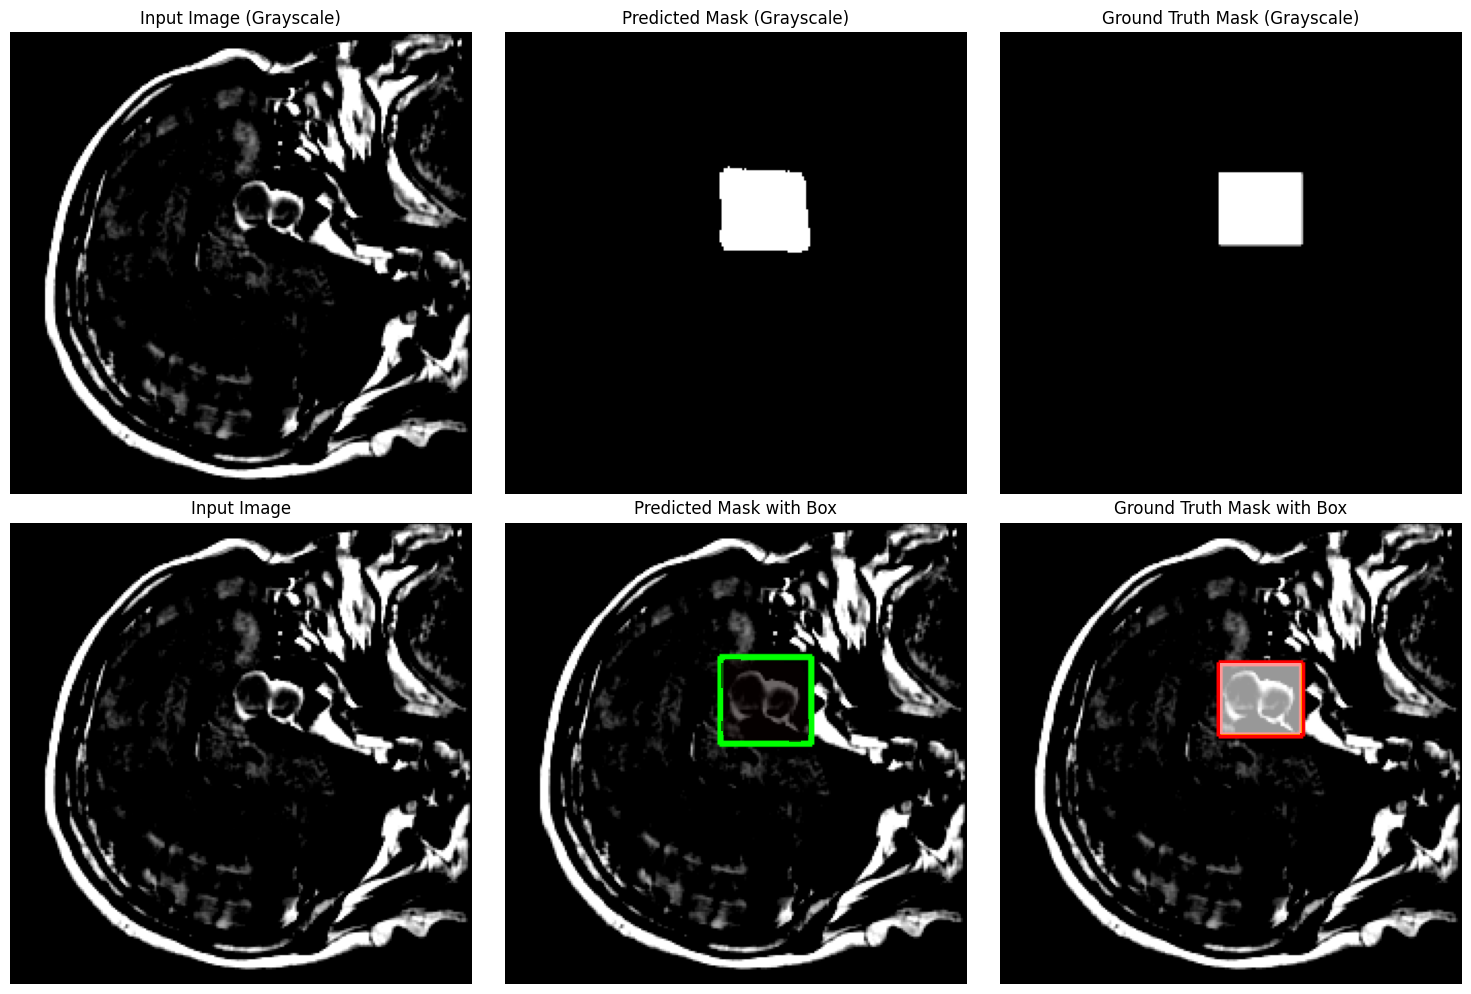

Prediction time for 32 images: 8.9718 seconds
Average loss for Test: 0.0017
Average accuracy for Test: 98.93%
Average prediction time per image: 0.2804 seconds


In [73]:
predict_and_visualize_with_seed(valid_loader, "Validation", model, loss_fn, seed=154)
predict_and_visualize_with_seed(test_loader, "Test", model, loss_fn, seed=51)

In [75]:
def get_model_size(checkpoint_path):
    file_size = os.path.getsize(checkpoint_path)  
    file_size_mb = file_size / (1024 * 1024) 
    print(f"Model file size: {file_size_mb:.2f} MB")

get_model_size(checkpoint_path)

Model file size: 372.60 MB
